## MNSIT Conditional GenAI
Using Tensorflow 

#### Candidate
Muhammad Mehroz



In [64]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gradio as gr


In [65]:
np.random.seed(10)
random_dim = 100

In [66]:
# Load the MNIST dataset and normalize each pixel value to 0-1 range.
def load_mnist():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train, x_test = (x_train - 127.5) / 127.5, (x_test - 127.5) / 127.5
    x_train = x_train.reshape((-1, 28, 28, 1))
    x_test = x_test.reshape((-1, 28, 28, 1))
    return x_train, y_train, x_test, y_testbatchnormalization

In [67]:
# Define a Generator
def define_generator(latent_dim):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(128 * 7 * 7, activation='relu', input_dim=latent_dim))
    model.add(tf.keras.layers.Reshape((7, 7, 128)))
    model.add(tf.keras.layers.UpSampling2D())
    model.add(tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.UpSampling2D())
    model.add(tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Conv2D(1, 3, padding='same', activation='tanh'))

    z = tf.keras.layers.Input(shape=(latent_dim,))
    label = tf.keras.layers.Input(shape=(1,), dtype='uint8')
    label_embed = tf.keras.layers.Embedding(10, latent_dim, input_length=1)(label)
    label_embed = tf.keras.layers.Flatten()(label_embed)
    combined = tf.keras.layers.multiply([z, label_embed])

    img = model(combined)

    return tf.keras.models.Model([z, label], img)

In [68]:
latent_dim = 100
g_model = define_generator(latent_dim)
g_model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_4 (Embedding)        (None, 1, 100)       1000        ['input_15[0][0]']               
                                                                                                  
 input_14 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 flatten_7 (Flatten)            (None, 100)          0           ['embedding_4[0][0]']            
                                                                                            

In [69]:
def define_discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), strides=2, input_shape=(28, 28, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=2, padding='same'))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.25))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    img = tf.keras.layers.Input(shape=(28, 28, 1))
    label = tf.keras.layers.Input(shape=(1,))
    label_embed = tf.keras.layers.Embedding(input_dim=10, output_dim=np.prod((28, 28)), input_length=1)(label)
    label_embed = tf.keras.layers.Flatten()(label_embed)
    label_embed = tf.keras.layers.Reshape((28, 28, 1))(label_embed)
    concatenated = tf.keras.layers.Concatenate(axis=-1)([label_embed, img])
    prediction = model(concatenated)
    return tf.keras.models.Model([img, label], prediction)


In [70]:
d_model = define_discriminator()
d_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 784)       7840        ['input_17[0][0]']               
                                                                                                  
 flatten_9 (Flatten)            (None, 784)          0           ['embedding_5[0][0]']            
                                                                                                  
 reshape_6 (Reshape)            (None, 28, 28, 1)    0           ['flatten_9[0][0]']              
                                                                                            

In [71]:
d_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [72]:

z = tf.keras.layers.Input(shape=(100,))
label = tf.keras.layers.Input(shape=(1,))
img = g_model([z, label])

d_model.trainable = False
prediction = d_model([img, label])
cgan = tf.keras.models.Model([z, label], prediction)
cgan.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
cgan.summary()


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_19 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 model_7 (Functional)           (None, 28, 28, 1)    857193      ['input_18[0][0]',               
                                                                  'input_19[0][0]']               
                                                                                                  
 model_8 (Functional)           (None, 1)            1633601     ['model_7[0][0]',          

In [73]:
x_train, y_train, x_test, y_test = load_mnist()

In [74]:
def plot_image(images, labels, rows, cols):
    fig = plt.figure(figsize=(8, 8))
    for i in range(1, cols * rows + 1):
        img = images[i - 1]
        ax = fig.add_subplot(rows, cols, i)
        ax.title.set_text(labels[i - 1])
        plt.imshow(img.reshape((28, 28)), cmap='gray')
        plt.axis('off')
    fig.tight_layout()
    plt.show()

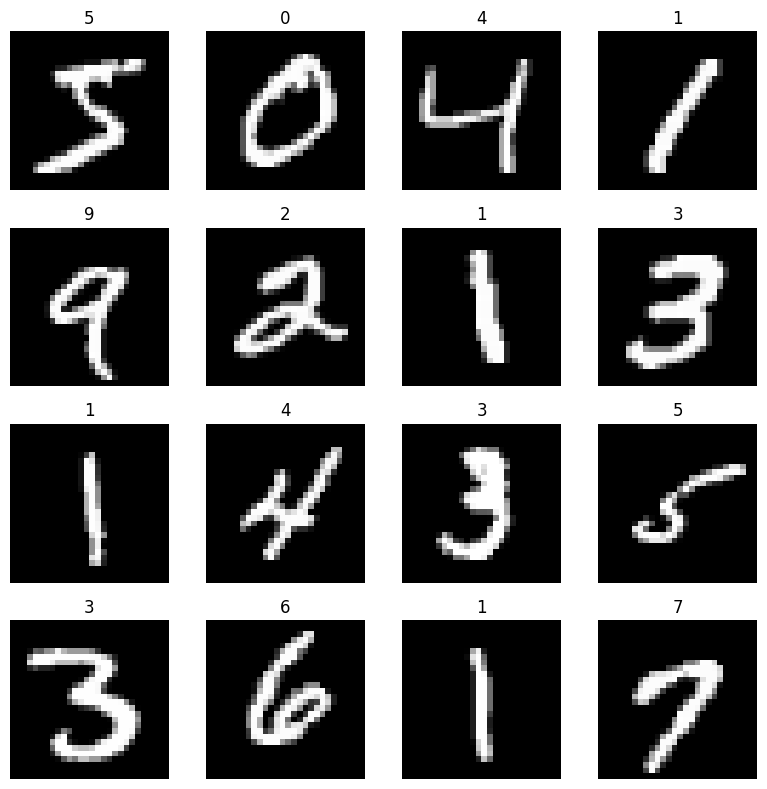

In [75]:
samples = x_train[:4 * 4]
labels = y_train[:4 * 4]
plot_image(samples, labels, 4, 4)

In [76]:
epochs = 15005
#epochs = 150
batch_size = 128
#save_interval = 1000
save_interval = 1000

valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))


In [77]:
losses = {"G": [], "D": []}

samples_test = np.random.normal(0, 1, (16, 100))
labels_test = np.random.randint(0, 10, 16).reshape((-1, 1))


4/4 [==============================] - 0s 13ms/step
Epoch 0, Losses (D, G): 0.7375102639198303, [0.1984328031539917, 1.0]
1/1 [==============================] - 0s 86ms/step


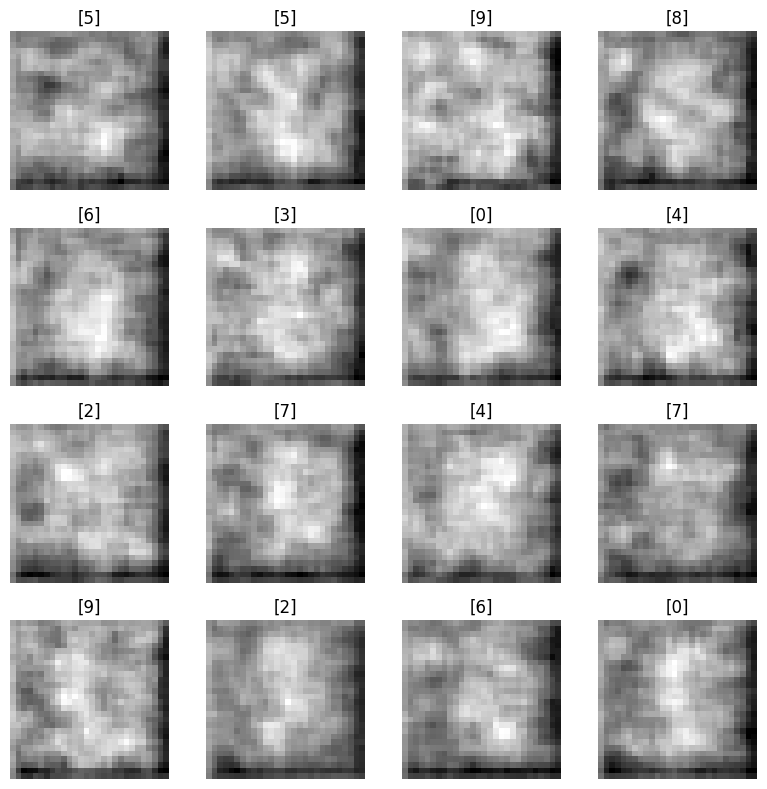

4/4 [==============================] - 0s 2ms/step
Epoch 1000, Losses (D, G): 0.014327945187687874, [7.162944793701172, 0.0]
1/1 [==============================] - 0s 18ms/step


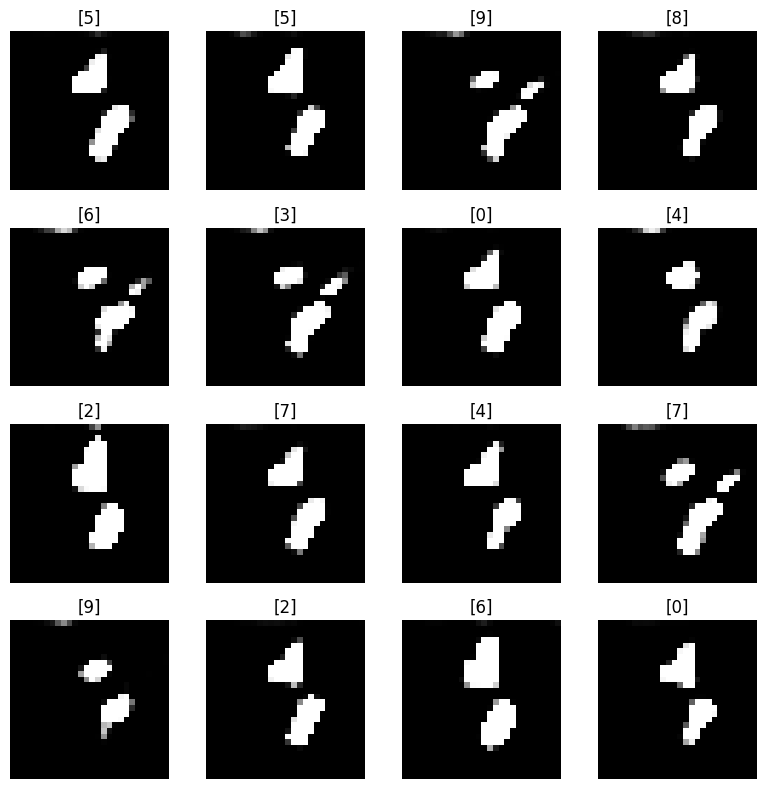

4/4 [==============================] - 0s 2ms/step
Epoch 2000, Losses (D, G): 0.32456330955028534, [2.395766019821167, 0.0703125]
1/1 [==============================] - 0s 17ms/step


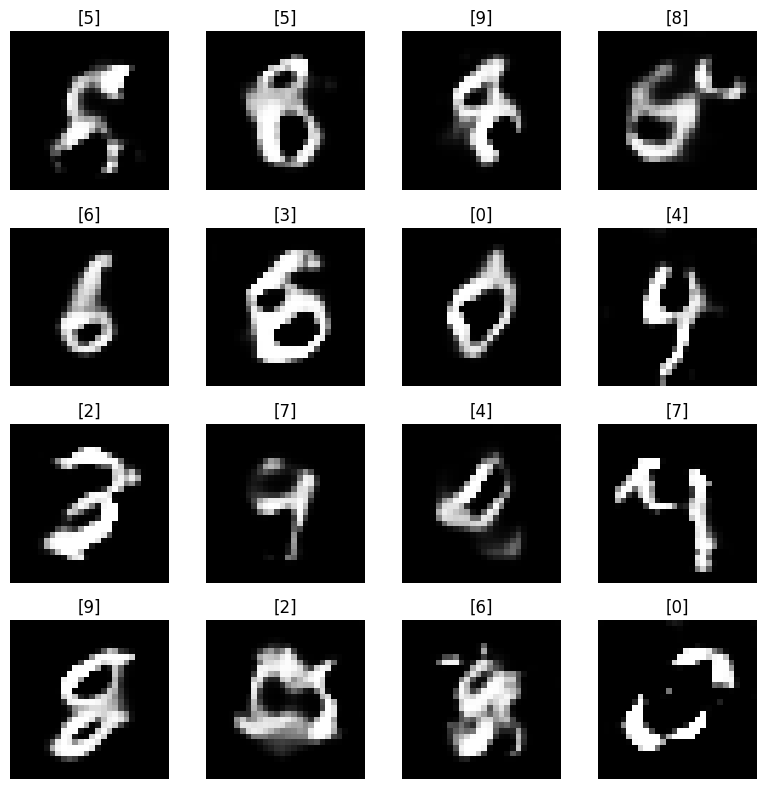

4/4 [==============================] - 0s 3ms/step
Epoch 3000, Losses (D, G): 0.44464097917079926, [1.7791802883148193, 0.1484375]
1/1 [==============================] - 0s 21ms/step


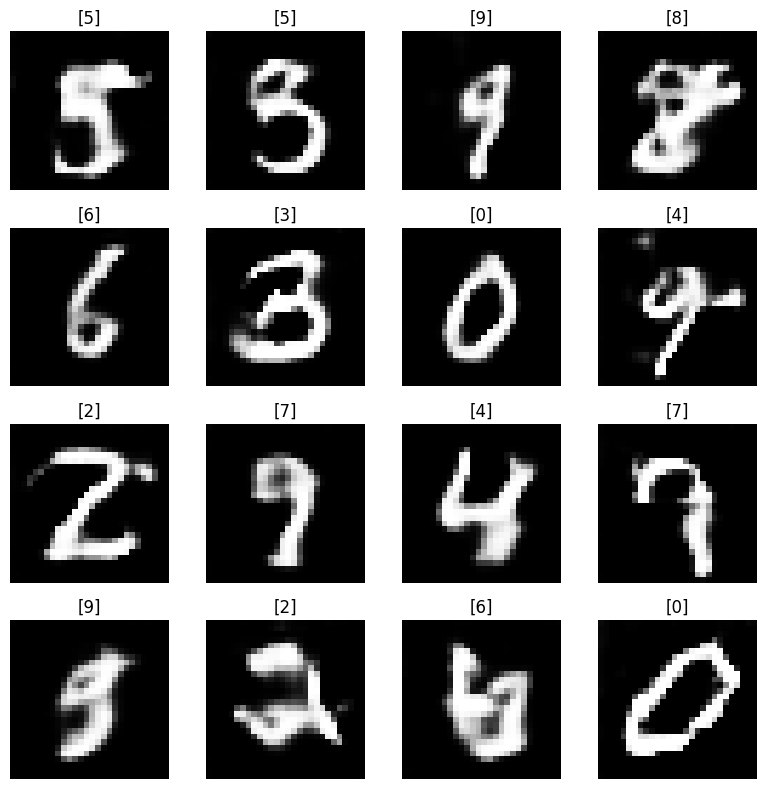

4/4 [==============================] - 0s 3ms/step
Epoch 4000, Losses (D, G): 0.5938532054424286, [1.3822247982025146, 0.2734375]
1/1 [==============================] - 0s 19ms/step


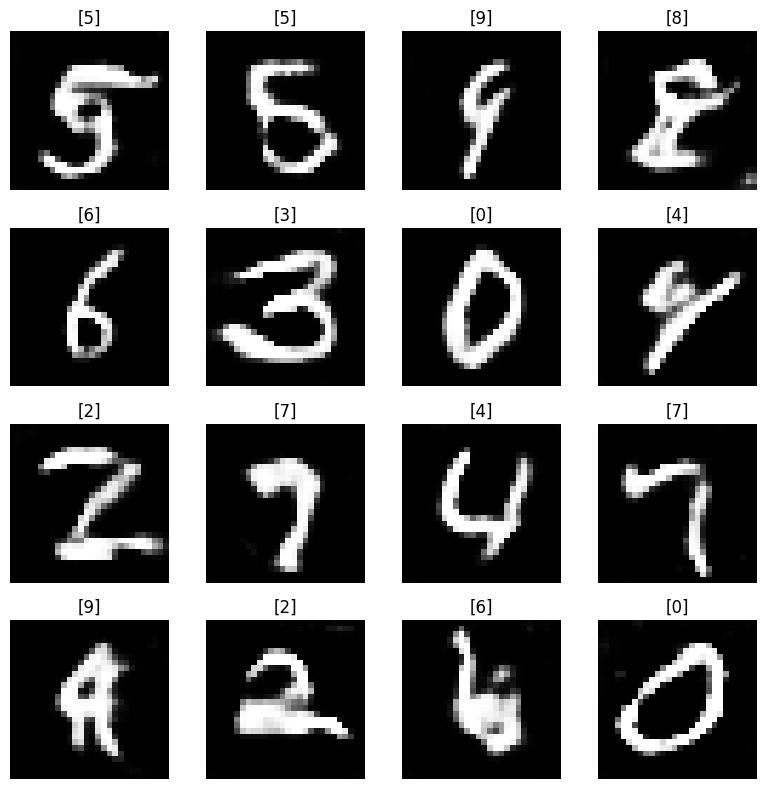

4/4 [==============================] - 0s 4ms/step
Epoch 5000, Losses (D, G): 0.5798128843307495, [1.0717761516571045, 0.296875]
1/1 [==============================] - 0s 20ms/step


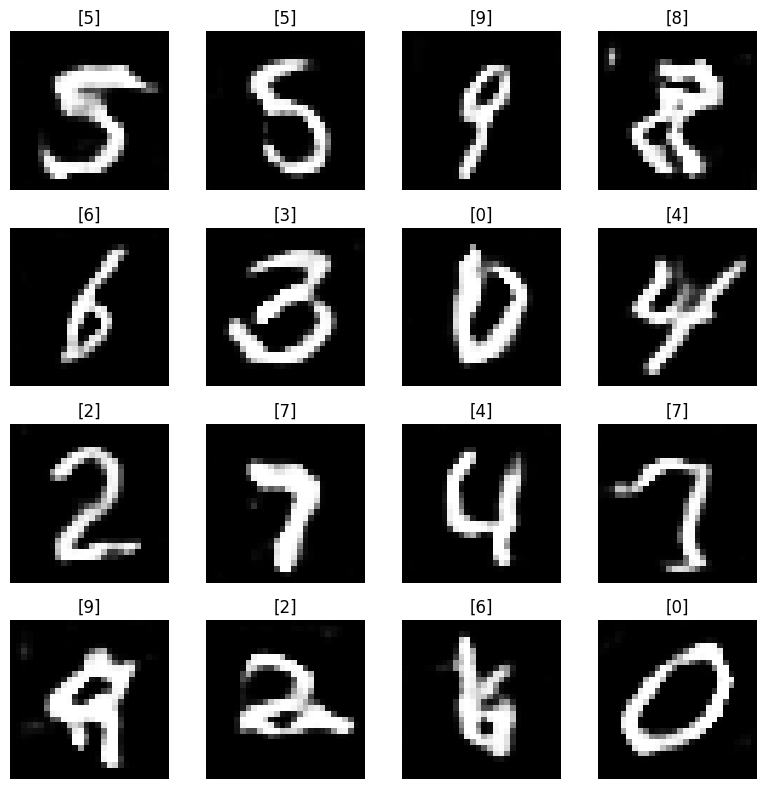

4/4 [==============================] - 0s 3ms/step
Epoch 6000, Losses (D, G): 0.5762050747871399, [1.1621512174606323, 0.1640625]
1/1 [==============================] - 0s 21ms/step


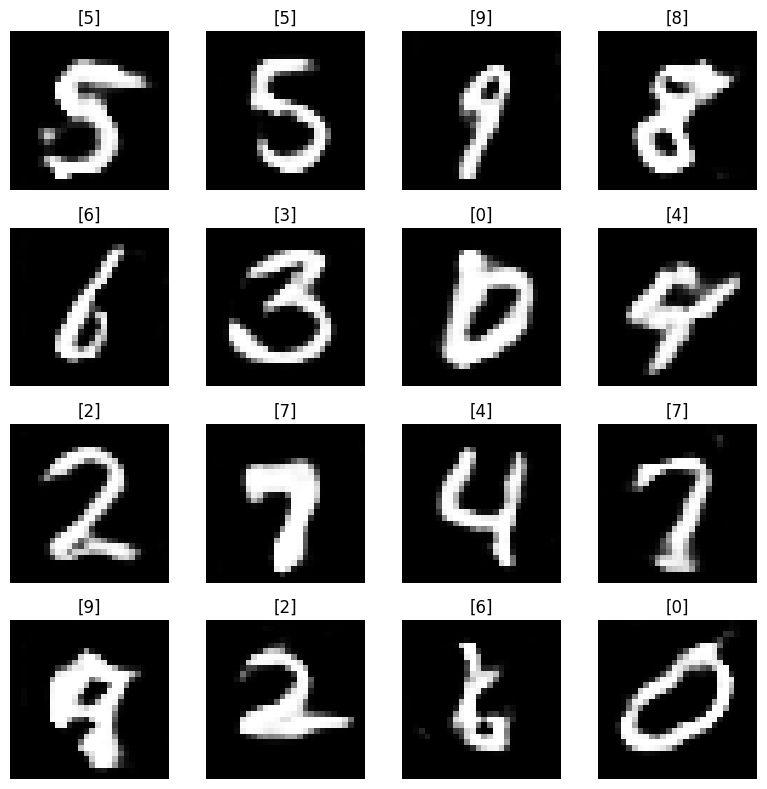

4/4 [==============================] - 0s 1ms/step
Epoch 7000, Losses (D, G): 0.5579904019832611, [1.0171587467193604, 0.2421875]
1/1 [==============================] - 0s 20ms/step


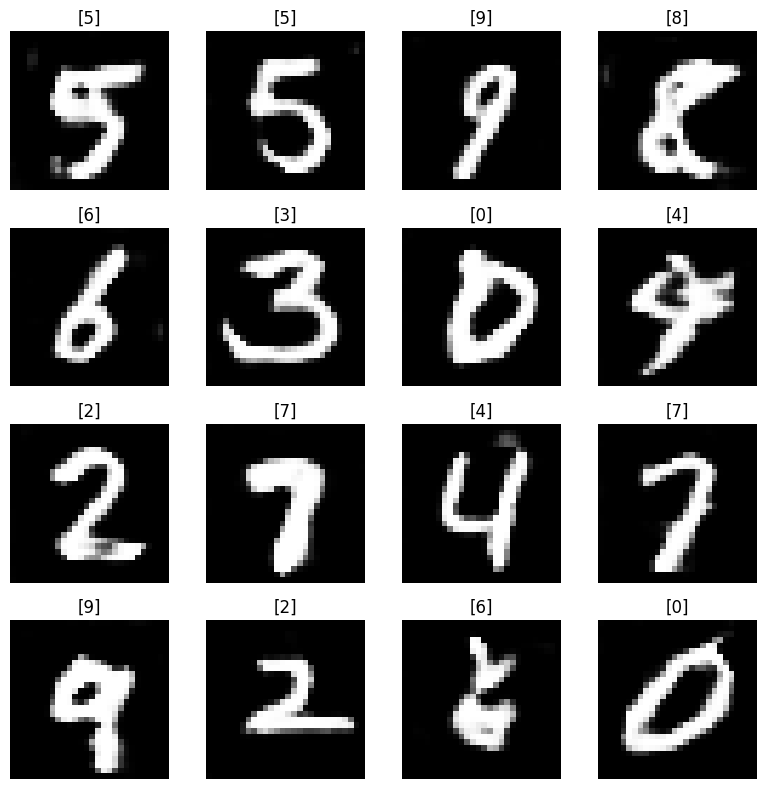

4/4 [==============================] - 0s 7ms/step
Epoch 8000, Losses (D, G): 0.5751373171806335, [1.0543007850646973, 0.265625]
1/1 [==============================] - 0s 103ms/step


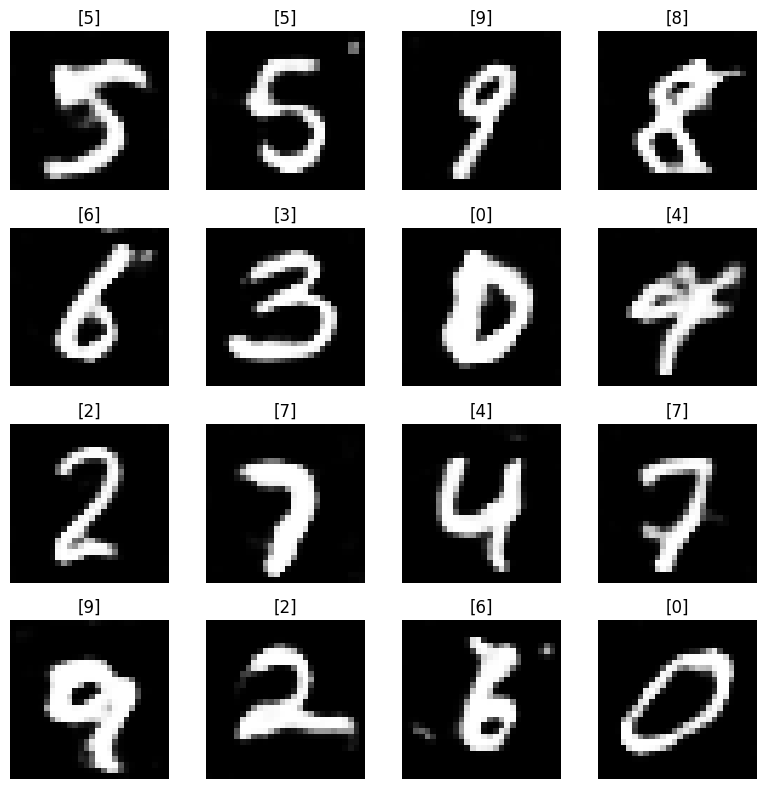

4/4 [==============================] - 0s 4ms/step
Epoch 9000, Losses (D, G): 0.5826510190963745, [1.2716642618179321, 0.15625]
1/1 [==============================] - 0s 22ms/step


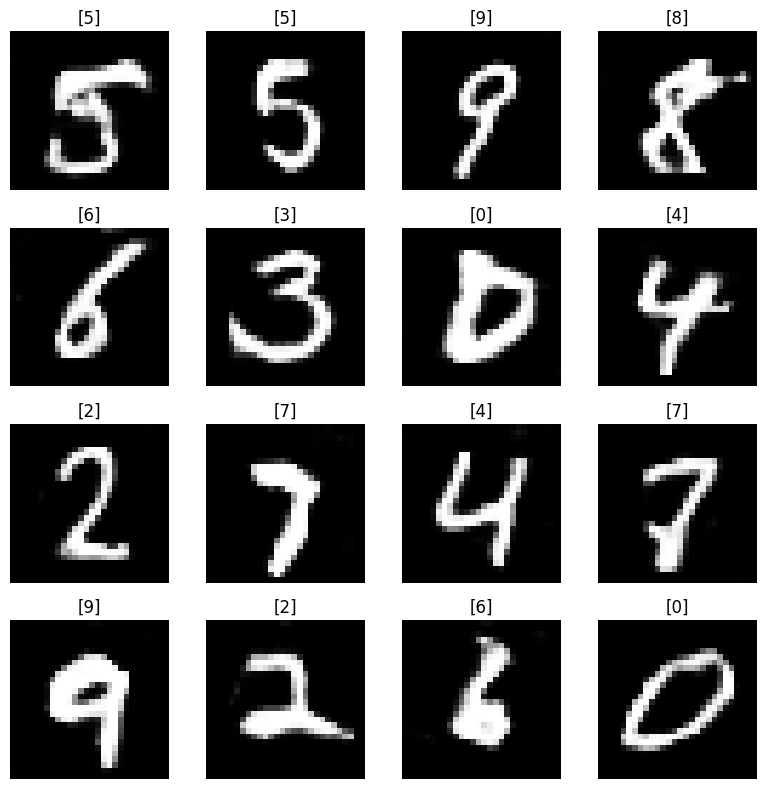

4/4 [==============================] - 0s 7ms/step
Epoch 10000, Losses (D, G): 0.6065255701541901, [1.0259541273117065, 0.2734375]
1/1 [==============================] - 0s 23ms/step


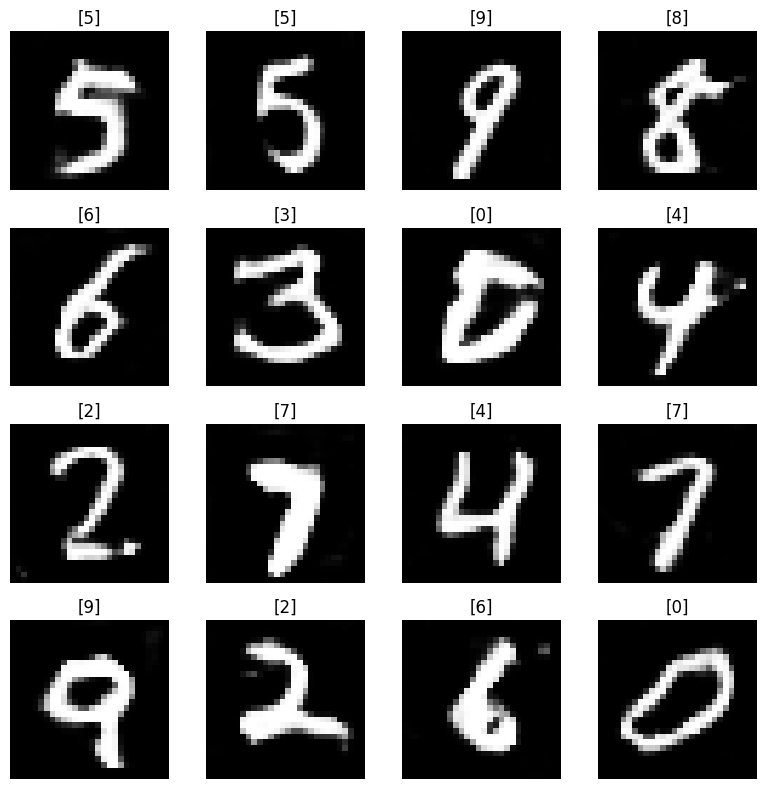

4/4 [==============================] - 0s 8ms/step
Epoch 11000, Losses (D, G): 0.5844338536262512, [1.1717982292175293, 0.296875]
1/1 [==============================] - 0s 63ms/step


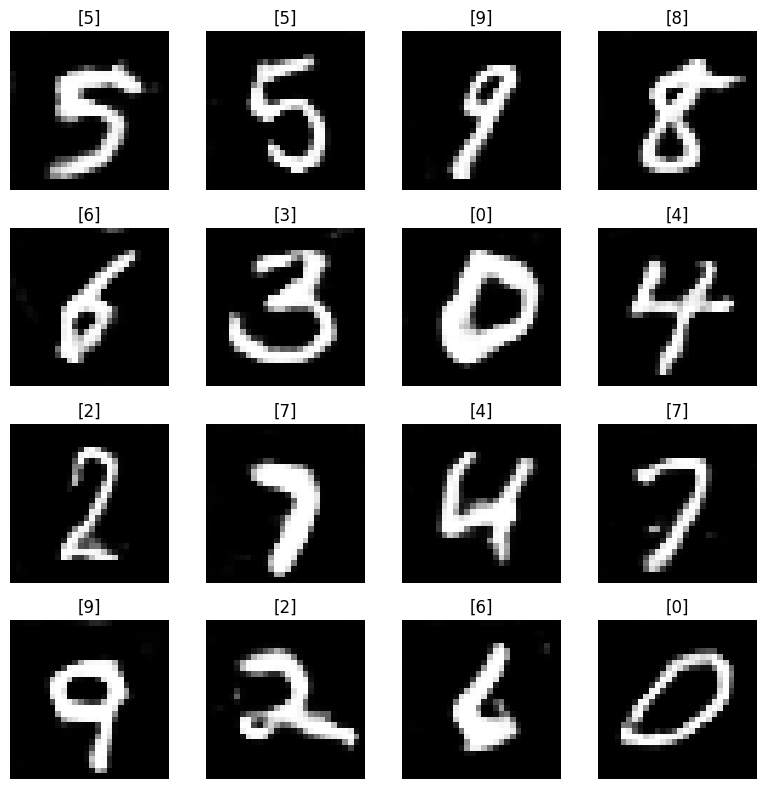

4/4 [==============================] - 0s 24ms/step
Epoch 12000, Losses (D, G): 0.6215618848800659, [1.1000961065292358, 0.203125]
1/1 [==============================] - 0s 134ms/step


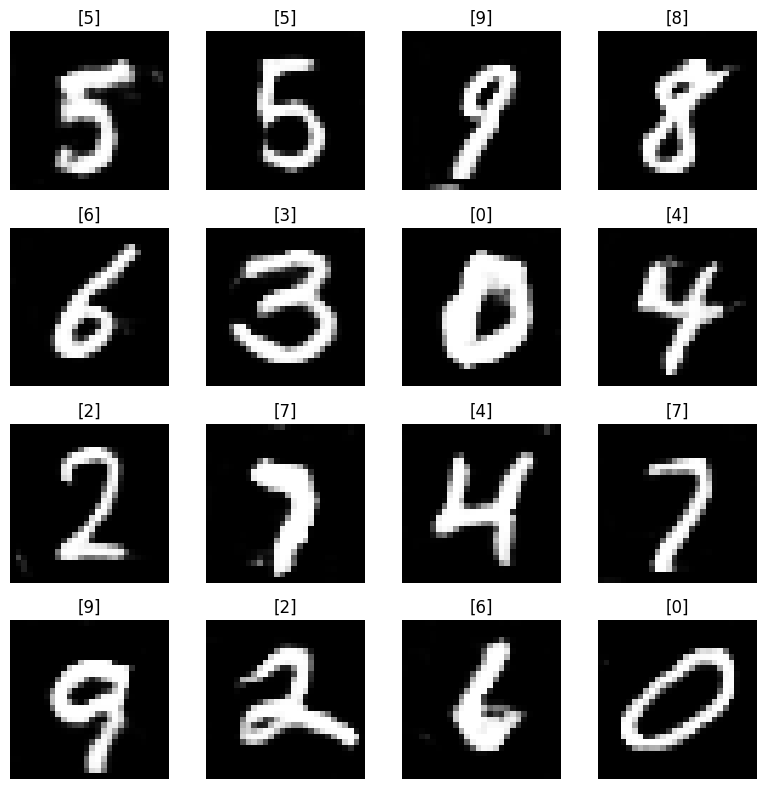

4/4 [==============================] - 0s 7ms/step
Epoch 13000, Losses (D, G): 0.5832848250865936, [1.155271053314209, 0.2265625]
1/1 [==============================] - 0s 32ms/step


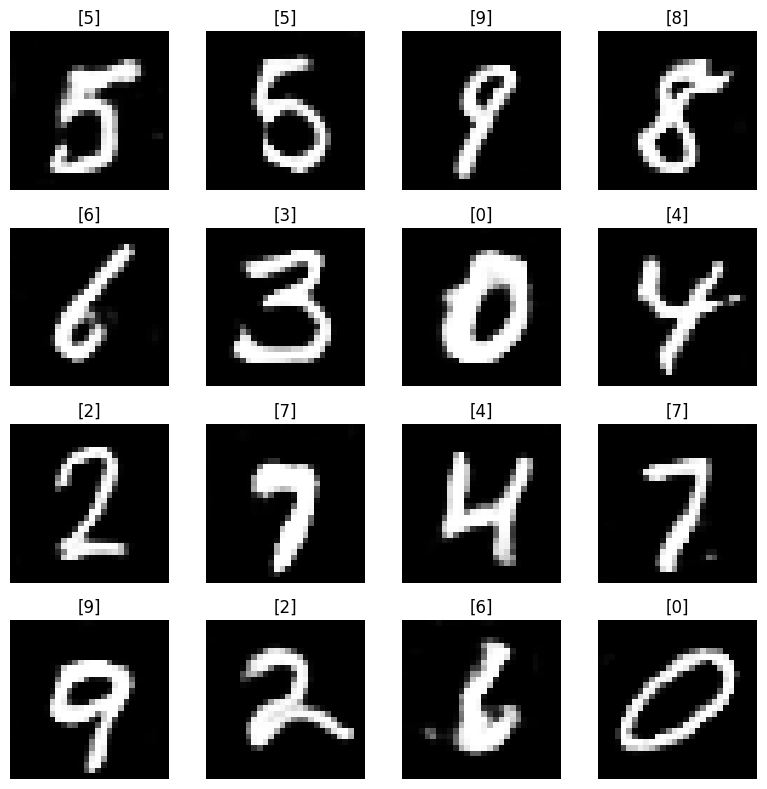

4/4 [==============================] - 0s 5ms/step
2
4/4 [==============================] - 0s 6ms/step
2
4/4 [==============================] - 0s 8ms/step
Epoch 14000, Losses (D, G): 0.6356554329395294, [0.9072256088256836, 0.3671875]
1/1 [==============================] - 0s 23ms/step


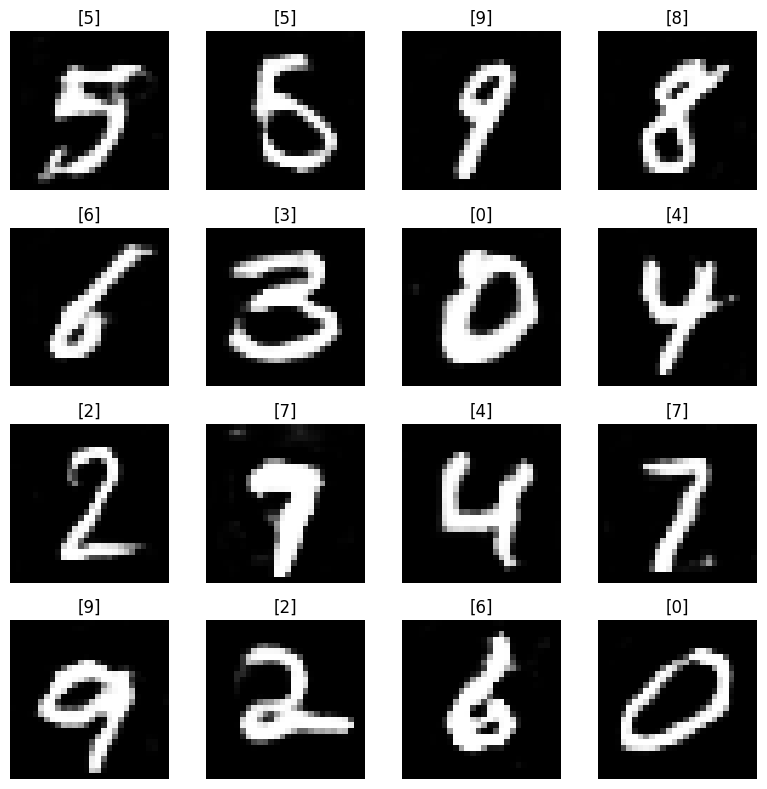

4/4 [==============================] - 0s 9ms/step
Epoch 15000, Losses (D, G): 0.6446030735969543, [1.0669597387313843, 0.2421875]
1/1 [==============================] - 0s 29ms/step


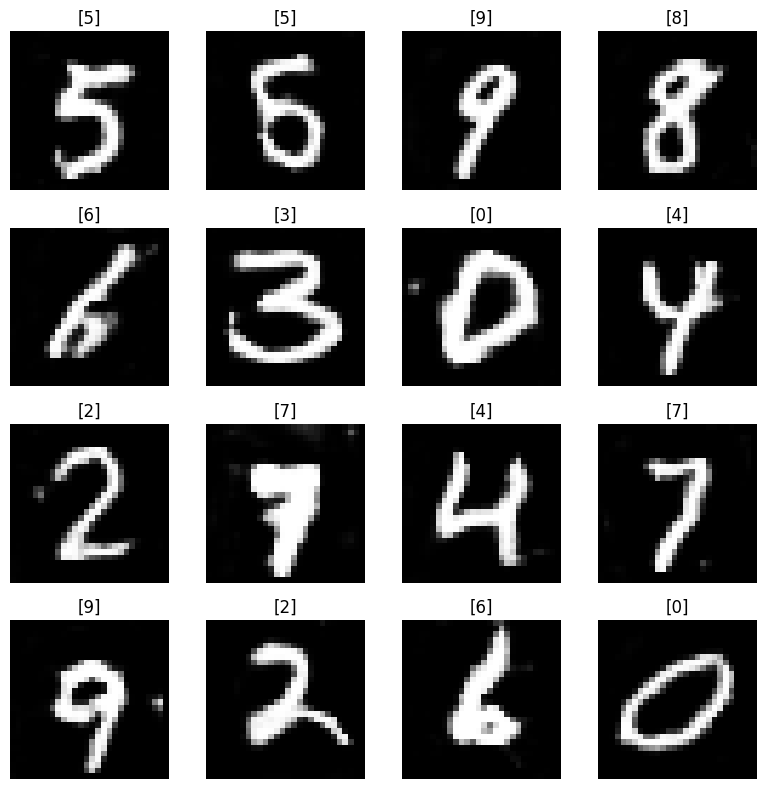

4/4 [==============================] - 0s 8ms/step


In [78]:
for epoch in range(epochs):
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs, labels = x_train[idx], y_train[idx]

    noise = np.random.normal(0, 1, (batch_size, 100))
    fake_imgs = g_model.predict([noise, labels])

    d_model.trainable = True
    d_loss_real = d_model.train_on_batch([real_imgs, labels], valid)
    d_loss_fake = d_model.train_on_batch([fake_imgs, labels], fake)

    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    d_model.trainable = False

    z = np.random.normal(0, 1, size=(batch_size, 100))
    labels = np.random.randint(0, 10, batch_size).reshape((-1, 1))

    g_loss = cgan.train_on_batch([z, labels], valid)

    losses["G"].append(g_loss)
    losses["D"].append(d_loss)

    if epoch % save_interval == 0:
        print(f"Epoch {epoch}, Losses (D, G): {d_loss[0]}, {g_loss}")
        results = g_model.predict([samples_test, labels_test])
        plot_image(results, labels_test, 4, 4)

In [79]:
# Function to generate images based on the input digit
def generate_digit_image(digit):
    digit = int(digit)
    print(digit)
    if digit < 0 or digit > 9:
        return "Please enter a digit between 0 and 9."

    noise = np.random.normal(0, 1, (1, random_dim))
    label = np.array([[digit]])

    generated_image = g_model.predict([noise, label])
    generated_image = generated_image.reshape(28, 28)

    return generated_image

In [83]:
d_model.save('discriminator2.h5')
g_model.save('generator2.h5')
cgan.save('cgan2.h5')

## UI using Gradio

In [84]:
from tensorflow.keras.models import load_model

In [94]:
gm = load_model("generator2.h5")

In [95]:
# Function to generate images based on the input digit
def generate_digit_image2(digit):
    digit = int(digit)
    print(digit)
    if digit < 0 or digit > 9:
        return "Please enter a digit between 0 and 9."

    noise = np.random.normal(0, 1, (1, random_dim))
    label = np.array([[digit]])

    generated_image = gm.predict([noise, label])
    generated_image = generated_image.reshape(28, 28)

    return generated_image

In [96]:
iface = gr.Interface(
    fn=generate_digit_image2,
    inputs=gr.Number( label="Enter a digit (0-9)"),
    outputs=gr.Image(type="numpy", label="Generated Image"),
    live=True
)# Launch the Gradio app
iface.launch()

Running on local URL:  http://127.0.0.1:7878

To create a public link, set `share=True` in `launch()`.


1
IMPORTANT: You are using gradio version 4.12.0, however version 4.29.0 is available, please upgrade.
--------
1/1 [==============================] - 0s 224ms/step
